# Chennai Water Management
## Exploratory Analysis

Chennai is a city located in the Indian state Tamil Nadu.  It serves as the capital of Tamil Nadu, and the city and surrounding area serve as a major economic centers in India.  It is also the place where both my parents (and most of my family) were born.

Recently this area has been suffering from serious water shortages.  This is due in part to two years of inadequate monsoon seasons, but increasing urbanization have caused some encroachment on water bodies in and around the region.  In this notebook I'm going through a dataset posted on Kaggle with the reservoir levels and rainfall levels in Chennai from 2004 until June 2019.  I'll be looking through to see if we can identify any trends in the data, and by providing visuals hopefully I can share just how dire the situation in Chennai is.  Perhaps we can see whether or not the rainfall data included is tied to the reservoir levels.

I won't be presenting this in a very formal setting, instead I'll treat this more as a tutorial and a walkthrough of my thought process on analyzing this data.

---

## Reading in the data

In [5]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

Since both input files have the same format (a date column and then 4 columns specifying areas in Chennai and their respective reservoir/rainfall levels) we can define a standard method to read in the data, appropriately parse the date column, and return a sorted frame.  We sort just in case the data itself does not come to us sorted.

In [6]:
def read_input_file(filepath):
    """Reads in the input files located by the filepath <str> argument and returns a parsed dataframe."""
    
    frame = pd.read_csv(filepath)
    frame['Date'] = pd.to_datetime(frame['Date'], format='%d-%m-%Y')
    frame = frame.sort_values('Date', ascending=True).reset_index(drop=True)
    return frame

In [7]:
reservoir_levels = read_input_file(r'chennai-water-management/chennai_reservoir_levels.csv')
rainfall = read_input_file(r'chennai-water-management/chennai_reservoir_rainfall.csv')

---

## Taking a first look

So first let's take a look at the data we have, we can verify that the two dataframes have the same format of rows and columns.

In [8]:
reservoir_levels.head()

,Date,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
0,2004-01-01,3.9,0.0,268.0,0.0
1,2004-01-02,3.9,0.0,268.0,0.0
2,2004-01-03,3.9,0.0,267.0,0.0
3,2004-01-04,3.9,0.0,267.0,0.0
4,2004-01-05,3.8,0.0,267.0,0.0


In [9]:
rainfall.head()

,Date,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
0,2004-01-01,0.0,0.0,0.0,0.0
1,2004-01-02,0.0,0.0,0.0,0.0
2,2004-01-03,0.0,0.0,0.0,0.0
3,2004-01-04,0.0,0.0,0.0,0.0
4,2004-01-05,0.0,0.0,0.0,0.0


Excellent, it looks like our data has been read in no problem.  We see above that there are ascending dates starting from January 1st, 2004 for both dataframes on the far left, and that the subseqent columns document the reservoir levels and rainfall levels per-day for each of the main reservoirs in Chennai.

I happen to know that there's no missing data in this dataset (although whether or not the data is accurate remains to be seen).  We can verify that there's no missing data by checking to see how many of the reservoir columns are null with the `isnull()` method.  This method returns a boolean frame (a frame replacing each response with `True` or `False` values) documenting where the condition we're checking for (data is `null`) is `True`.  In Python, `True` is an alias for the value `1` and `False` is an alias for `0`.  Therefore, if we sum across all columns in this boolean frame, we'll get a count of all the responses that are null.  If we do this below, we'll see the sums for both frames is `0`, indicating that there are no `null` values.

In [10]:
print(reservoir_levels.isnull().sum(), '\n\n', rainfall.isnull().sum())

Date               0
POONDI             0
CHOLAVARAM         0
REDHILLS           0
CHEMBARAMBAKKAM    0
dtype: int64 

 Date               0
POONDI             0
CHOLAVARAM         0
REDHILLS           0
CHEMBARAMBAKKAM    0
dtype: int64


It might also help if we know the date range that this data encompasses.  I know we mentioned in the intro that the date range is from January 2004 to June 2019, but in a real analysis if we were just starting out, we'd want to verify that.

In [11]:
start_date, end_date = reservoir_levels['Date'].min(), reservoir_levels['Date'].max()
print('Dataset Start Date:', start_date.strftime('%d-%b-%y'))
print('Dataset End Date:', end_date.strftime('%d-%b-%y'))

Dataset Start Date: 01-Jan-04
Dataset End Date: 17-Jun-19


Lets also take a look at a quick description of the columns so we can get an idea of the range of values we have to work with.

In [12]:
reservoir_levels.describe()

,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
count,5647.000000,5647.000000,5647.000000,5647.000000
mean,1133.272203,240.020572,1568.345573,1321.381645
std,1026.009311,274.601731,890.363617,957.057834
min,0.900000,0.000000,0.000000,0.000000
25%,213.000000,22.300000,849.000000,471.500000
50%,782.000000,92.000000,1630.000000,1225.000000
75%,2006.000000,460.000000,2236.000000,2083.000000
max,3231.000000,896.000000,3300.000000,3396.000000


In [13]:
rainfall.describe()

,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
count,5647.000000,5647.000000,5647.000000,5647.000000
mean,3.364486,3.617177,3.756862,3.923862
std,12.755029,14.078840,15.060551,16.287227
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,300.000000,293.000000,320.000000,475.000000


Great, so both frames have the same number of rows, again there are no missing values, and we get some extra info about the distribution of values.  Let's take some time to make a few remarks on the data that we're seeing.  Firstly, the mean value of the reservoir levels varies between each reservoir, however Cholavaram has the lowest reservoir levels of any reservoir in the dataset.  We can surmise that while Cholavaram does provide much  needed water to Chennai, it's contribution is quite low.

Also of note, the rainfall levels are very sparse.  We see that there are a large number of `0` values, implying that rainfall is nowhere near a daily occurrence in this region.  Also, for the most part the rainfall means across all regions are very similar, which we might expect, although the standard deviations and maximums are different.  That could imply that we have some faulty data or that some regions are simply slightly more prone to rain than others.

---

## Visualization

There's only so much we can get from a dataset by looking at the raw data as a table.  Let's try to take an initial look at the reservoir and rainfall levels in Chennai over time visually.  This will give us a much better sense of what our data looks like.

c:\users\xaviem01\appdata\local\continuum\anaconda2\envs\py3env\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


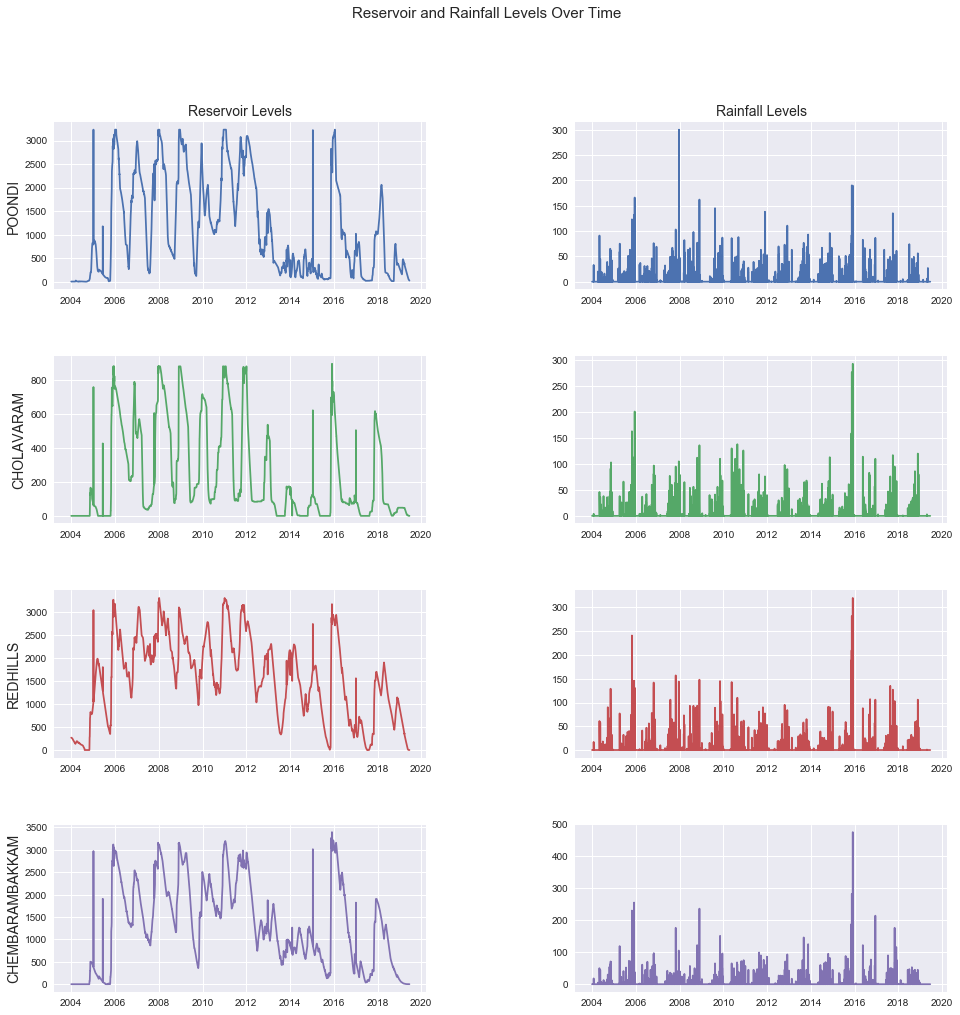

In [14]:
def plot_rainfall_and_reservoir_levels(reservoir_levels, rainfall, type='line', alpha=1):
    """
    Creates 8 plots, 4 rows and 2 columns, with one row per region in Chennai where the first
    "cell" holds the reservoir levels over time and the second holds rainfall levels over time.
    The 'type' variable determines the output is a line plot (type = 'line') or if the output is
    a barplot (type != 'line').
    """
    fig, ax = plt.subplots(4, 2, figsize=(16, 16))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for index, column in enumerate(reservoir_levels.columns[1:]):
        c = colors[index]
        if type == 'line':
            ax[index][0].plot(reservoir_levels['Date'], reservoir_levels[column], color=c, alpha=alpha)
            ax[index][1].plot(rainfall['Date'], rainfall[column], color=c, alpha=alpha)
        else:
            ax[index][0].bar(reservoir_levels['Date'], reservoir_levels[column], color=c, alpha=alpha)
            ax[index][1].bar(rainfall['Date'], rainfall[column], color=c, alpha=alpha)
        ax[index][0].set_ylabel(column, size=14)
    ax[0][0].set_title('Reservoir Levels', size=14)
    ax[0][1].set_title('Rainfall Levels', size=14)
    fig.suptitle('Reservoir and Rainfall Levels Over Time', size=15)

plot_rainfall_and_reservoir_levels(reservoir_levels, rainfall)

So based on what we see above it does look like rainfall and reservoir levels are tied to eachother, which may not be a shocking finding but it's always worth taking a quick look to make sure your intuition is correct.  Visually we can confirm that Cholavaram again does have low reservoir levels given the rainfall levels, but we already surmised that before.  We can also see that the reservoir levels are cyclical, and that the reservoirs all experienced lower levels in 2014-2015 and in 2018-2019.  We also see that 2004 has very low reservoir levels.

Since we're interested in how the rainfall levels tie together with the reservoir levels, let's plot them together and see if we can identify any trends.

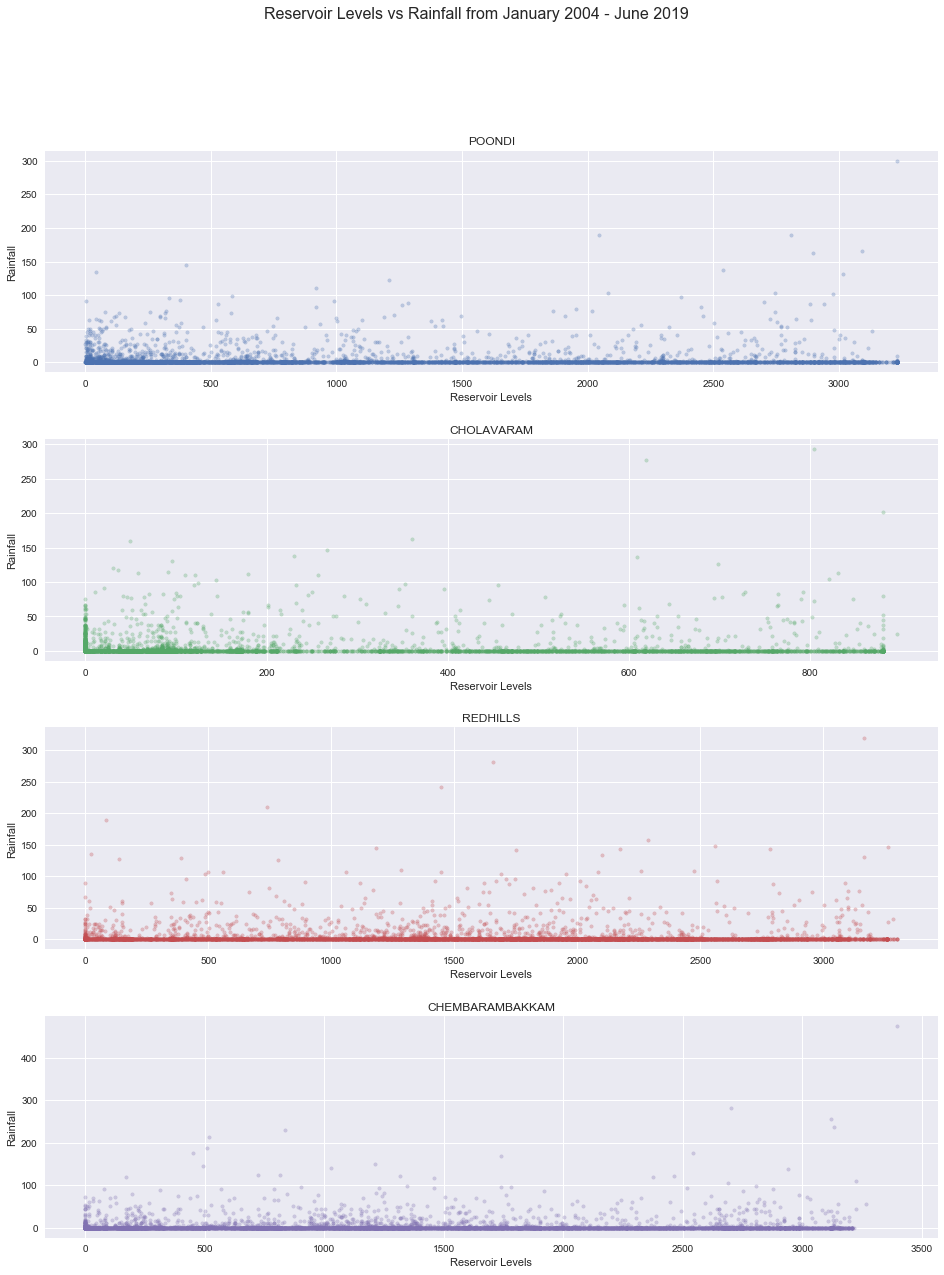

In [15]:
# Fof each region, plot reservoir levels vs rainfall levels
fig, ax = plt.subplots(4, 1, figsize=(16, 20))
for index, column in enumerate(reservoir_levels.columns[1:]):
    ax[index].scatter(reservoir_levels[column], rainfall[column], marker='.', color=colors[index], alpha=0.3)
    ax[index].set_ylabel('Rainfall')
    ax[index].set_title(column)
    ax[index].set_xlabel('Reservoir Levels')
fig.suptitle('Reservoir Levels vs Rainfall from January 2004 - June 2019', size=16)
fig.subplots_adjust(hspace=0.3)

There doesn't seem to be much of a linear, or really any trend here.  I plotted the colors with an alpha level of `0.3` so that we can easily see areas of high density vs areas of low density.  A lot of the rainfall levels are `0` despite the reservoir levels.  We made the observation previously that the rainfall levels are mostly `0`, so perhaps this isn't surprising; however if we didn't know exactly how unrelated these day-to-day data are this visual helps us clarify that there's not much to see here.

Let's return to this relationship a little later, first I'd like to see on aggregate, per year, how the two variables relate over time.  First, I'll do this by summing all the values for each reservoir/region per year, and then we'll plot that.  This tells us the total amount of rain that fell in each region per year, and the total reservoir level through each year.

Why would this second point help us?  Summing reservoir levels over the course of the year doesn't seem very helpful, if the reservoir level was some real value $x$ yesterday and is now %x - n$, how is summing these two values helpful?  Mostly I'm doing this because it gives us a good point of comparison between years.  If the sum across the entire year for reservoir levels is less than that of other years, we can assume that either the reservoir drained faster than in other years or that it wasn't filled enough in the given year.  That'll give us insight as to which years were bad for the reservoirs.

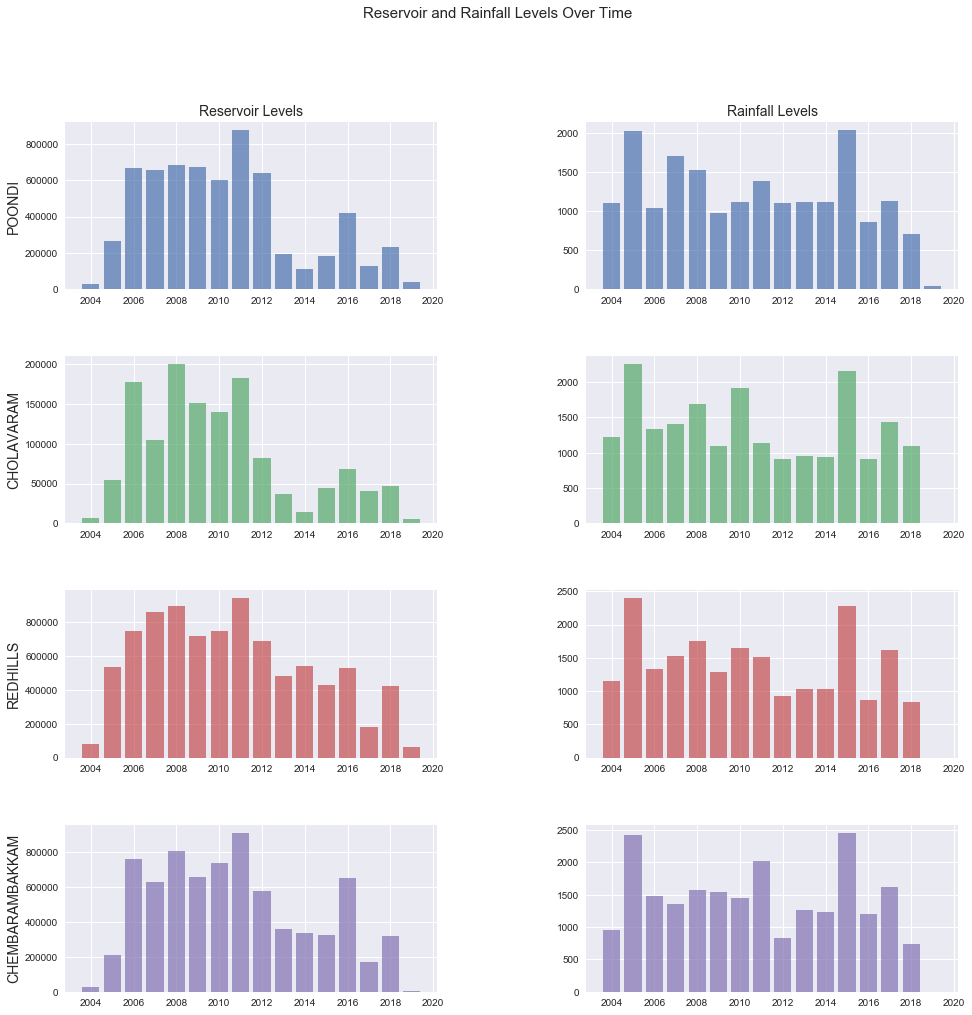

In [16]:
res_year = reservoir_levels.groupby(reservoir_levels.Date.dt.year).sum().reset_index()
rain_year = rainfall.groupby(rainfall.Date.dt.year).sum().reset_index()
plot_rainfall_and_reservoir_levels(res_year, rain_year, 'bar', 0.7)

A couple of things from the plots above.  We can clearly see firstly that reservoir levels are in fact decreasing.  All the regions are doing worse in more recent years than in previous years.  Some regions are doing very poorly, like Cholavaram (which already has a very low mean reservoir level).

Secondly, it does appear that 2018 was not a very good rainfall year (which is one of the listed reasons for the drought that's occurring in Chennai now).  A few of the other years look similar, 2012-2014 appears to have low rainfall levels and we see corresponding decreases in reservoir levels in most of the regions.  Right now, I'm interested in how bad 2018 was, so let's take a look at the aggregated rainfall across all the regions per year.

Text(0.5, 1.0, 'Rainfall Across All 4 Chennai Regions by Year')

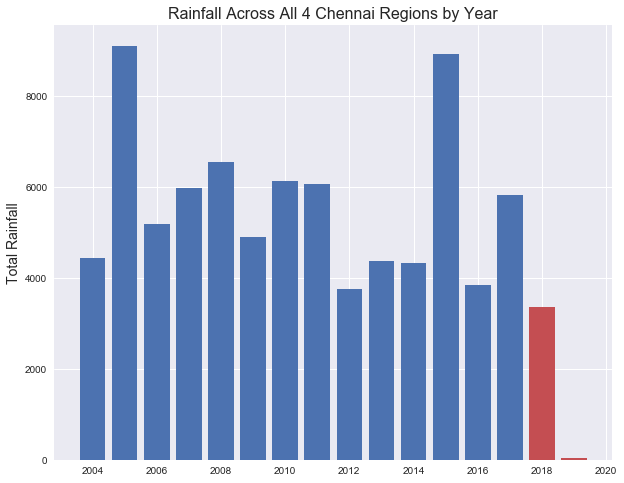

In [24]:
# Aggregate per year
rain_year_aggregate = rain_year.iloc[:, 1:].sum(axis=1)
c = [colors[0] for i in range(rain_year_aggregate.shape[0] - 2)]
c += [colors[2] for i in range(2)]

plt.figure(figsize=(10, 8))
plt.bar(rain_year['Date'], rain_year_aggregate, color=c)
plt.ylabel('Total Rainfall', size=14)
plt.title('Rainfall Across All 4 Chennai Regions by Year', size=16)

2018 does appear to have a low amount of rainfall, and there were similarly low amounts in 2016 and 2012-2014.  Chennai gets much of its water during monsoon season, which starts in October and goes through December.  According to [wikipedia](https://en.wikipedia.org/wiki/Climate_of_Tamil_Nadu) the dry season begins in February and goes through early June.  Perhaps then we should take a look at the reservoir levels at the start of the dry season, since this is the time that the reservoir levels are most crucial.  By looking at the start of the dry season, we can see how prepared Chennai will be until the next monsoon season.

In [25]:
# Subset to the beginning of February for each year
is_february = reservoir_levels['Date'].dt.month == 2
is_day_one = reservoir_levels['Date'].dt.day == 1
dry_season_res_levels = reservoir_levels.loc[is_february & is_day_one, :].reset_index(drop=True)
dry_season_res_levels

,Date,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
0,2004-02-01,4.8,0.0,220.0,0.0
1,2005-02-01,851.4,56.5,1458.0,275.0
2,2006-02-01,3035.0,721.0,2624.0,2843.0
3,2007-02-01,2565.0,545.0,3106.0,2157.0
4,2008-02-01,3061.0,867.0,3022.0,2960.0
5,2009-02-01,3025.0,778.0,2528.0,2679.0
6,2010-02-01,1493.0,686.0,2342.0,2254.0
7,2011-02-01,3108.0,840.0,3254.0,3080.0
8,2012-02-01,3048.0,495.0,2771.0,2719.0
9,2013-02-01,1359.0,398.0,2212.0,980.0


Text(0.5, 1.0, 'Reservoir Levels at the beginning of Dry Season in Chennai')

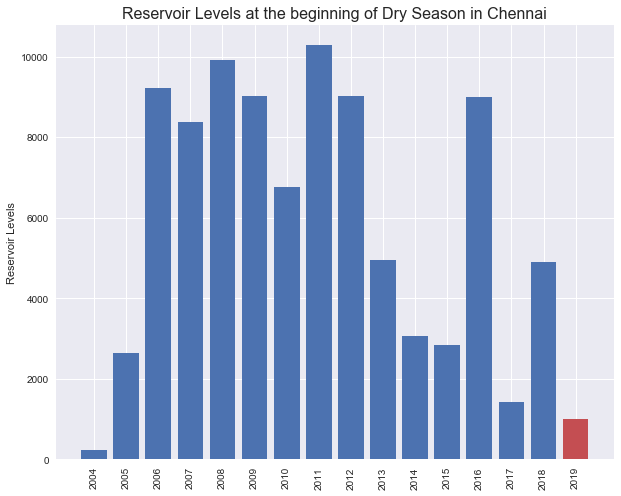

In [19]:
# Sum reservoir levels across all 4 regions per year
dry_season_res_all_regions = dry_season_res_levels.iloc[:, 1:].sum(axis=1)
x_tick_locations = range(dry_season_res_levels.shape[0])
c = [colors[0] for i in range(dry_season_res_levels.shape[0] - 1)]
c.append(colors[2])

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(x_tick_locations, dry_season_res_all_regions, color=c)
ax.set_xticks(x_tick_locations)
ax.set_xticklabels(dry_season_res_levels.Date.dt.strftime('%Y'), rotation=90)
ax.set_ylabel('Reservoir Levels')
ax.set_title('Reservoir Levels at the beginning of Dry Season in Chennai', size=16)

It certainly does appear that on February 1st, 2019 the Chennai experienced very low reservoir levels, less than any year other than 2004, evidence that the drought is real and we can see it here.

Before we move one let's visualize the reservoir levels per day based on the seasonal information we got from wikipedia.  Below, we'll plot the trends in reservoir levels over time vs the season (dry season from February through June 15th, monsoon season from October through December, and the rest of the months as "regular" weather).  Maybe we can identify what made 2018/2019 so different from other years.

Text(0.5, 1.0, 'Reservoir Levels in Chennai per Day')

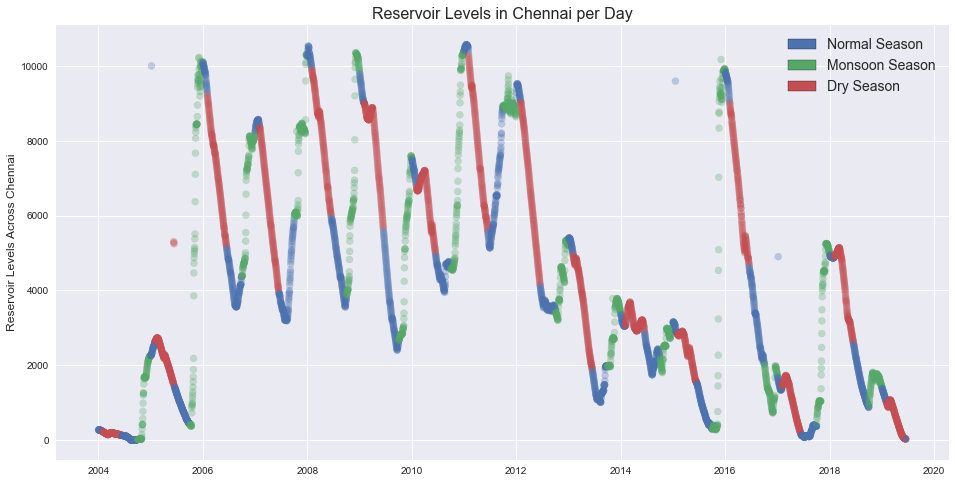

In [30]:
def assign_temporal_categories(date):
    """Given a date, determines whether to color for 'Monsoon', 'Dry', or 'Regular' season."""
    
    if date.month in [2, 3, 4, 5] or date.month == 6 and date.day <= 15:
        return colors[2]
    elif date.month in [10, 11, 12]:
        return colors[1]
    else:
        return colors[0]

# Plot the reservoir levels per day summed across all 4 reservoirs
c = reservoir_levels['Date'].apply(assign_temporal_categories, colors)
chennai_reservoirs = reservoir_levels.iloc[:, 1:].sum(axis=1)

plt.figure(figsize=(16, 8))
plt.scatter(reservoir_levels['Date'], chennai_reservoirs, color=c, alpha=0.3)
plt.ylabel('Reservoir Levels Across Chennai', size=12)
legend_labels = {'Normal Season':colors[0], 'Monsoon Season':colors[1], 'Dry Season':colors[2]}
leg_el = [mpatches.Patch(facecolor=value, edgecolor='k', label=key) for key, value in legend_labels.items()]
plt.legend(handles=leg_el, prop={'size':14})
plt.title('Reservoir Levels in Chennai per Day', size=16)

Above we've plotted the total reservoir levels in Chennai per day (by summing the reservoir levels per region) and colored in the regions according to the weather breakdown from wikipedia.  As we can see, often during the dry season there is a drop in water levels, although this appears to continue after dry season until monsoon season hits again (we see this trend in 2008, 2009, and 2016).  Also, the monsoon season in 2017 didnt lead to a significant increase in reservoir levels, and the dry season in 2018 depleted reservoirs to critical levels.  The monsoon season in 2018 provided very little relief.

One thing to note, it appears that we may have some outlier data here.  Some of the points on the scatter plot, especially between 2004-2006, one point around 2015, and one point around 2017 appear to be quite off.  This could be incorrect data from faulty sensors, mis-entered data, it could be that some of the surrounding data is actually incorrect (that seems unlikely), etc.  At this point, if this would be a real issue for us, we'd have to go back to the source and determine why these numbers are so off.  Also, if we were to try to develop a model, we'd need to determine whether or not we should keep these outlier data.

Creating a model is a little outside of the scope of this notebook, however we may wind up doing that in future notebooks.  For now, let's return to that scatter plot we made up above comparing rainfall per day to reservoir levels per day.  We determined that it there really wasn't a strong correlation (at least visually) between the two.  But intuitively we also note that rainfall affects future days as well as the present day, that is if it rained a month ago you would expect that to affect reservoir levels today.  Let's see if we can visualize this correlation by aggregating rainfall across some number of months.

In [31]:
def get_rolling_rainfall_levels(reservoir_levels, rainfall, days):
    """
    Returns a dataframe with the reservoir level per day and the total
    accumulated rainfall over the past [days] days.
    """
    
    rolling_rainfall = rainfall.iloc[:, 1:].sum(axis=1).rolling(days).sum()
    reservoir_sum_per_day = reservoir_levels.iloc[:, 1:].sum(axis=1)
    merged_frame = pd.concat([reservoir_sum_per_day, rolling_rainfall], axis=1)
    return merged_frame.dropna().reset_index(drop=True)

Text(0.45, 0.05, 'Reservoir Levels')

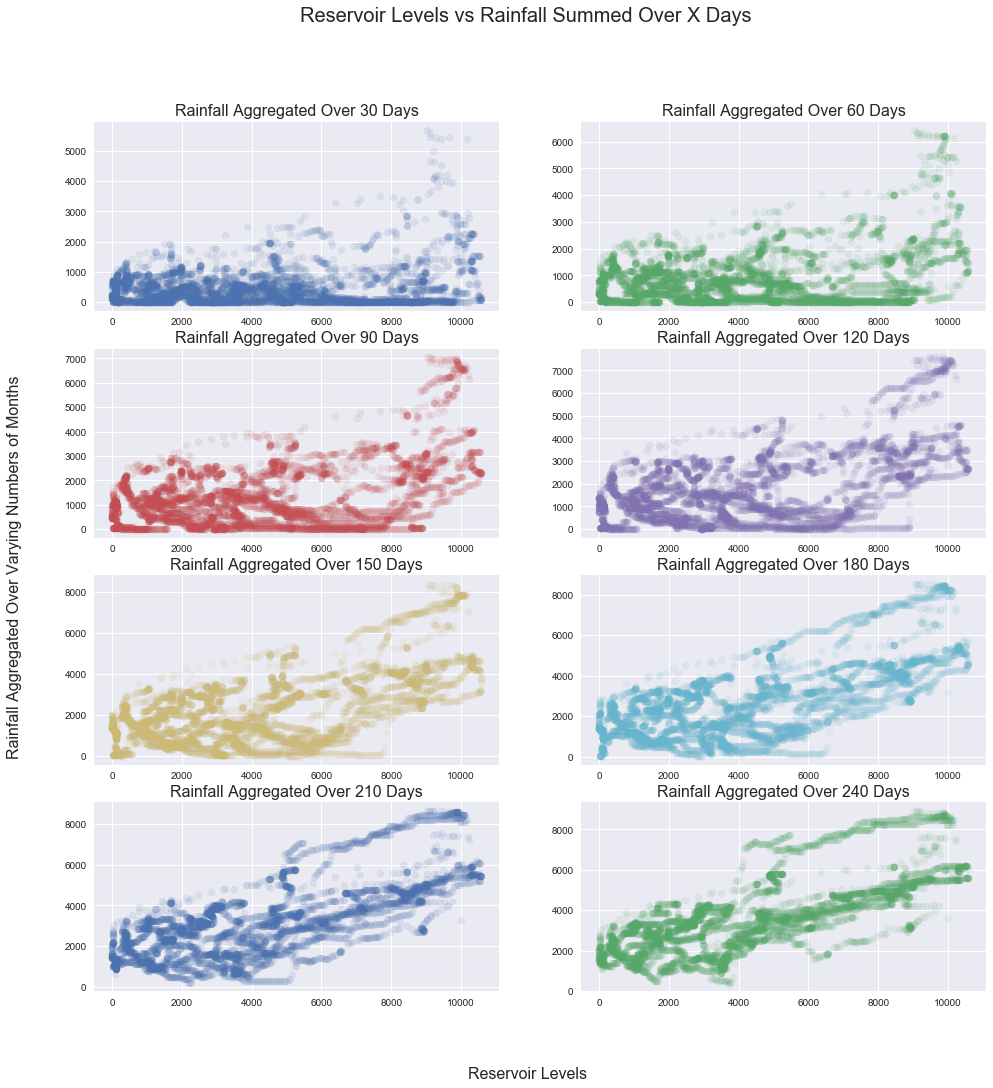

In [35]:
# Try aggregating rainfall from 1 month to 8 months
n_days = 30
n_months = 8
months = [i for i in range(30, (n_months + 1) * 30, 30)]
data = [get_rolling_rainfall_levels(reservoir_levels, rainfall, month) for month in months]

# Plot each scatter plot
nrows = math.ceil(len(months) / 2)
fig, ax = plt.subplots(nrows, 2, figsize=(16, 16))
for index, frame in enumerate(data):
    x_index = math.floor(index / 2)
    y_index = math.floor(index % 2)
    ax[x_index][y_index].scatter(frame[0], frame[1], alpha=0.1, color=colors[index % len(colors)])
    ax[x_index][y_index].set_title('Rainfall Aggregated Over %d Days' % months[index], size=16)
    
fig.suptitle('Reservoir Levels vs Rainfall Summed Over X Days', size=20)
fig.text(0.05, 0.65, 'Rainfall Aggregated Over Varying Numbers of Months', rotation=90, size=16)
fig.text(0.45, 0.05, 'Reservoir Levels', size=16)

We can see above that indeed the amount of rainfall over the course of the past influences the water level "today".  It also appears that the further back we check, the more of a relationship we see.  We could definately use this rolling sum to model reservoir levels, however we'd have to impute the data for days where the rolling sum fails (the first $X$ days) or drop that data.  Neither of these is completely desirable, although imputing allows us to save some of the data.  The cost of dropping 6-8 months of data is pretty high in a dataset with ~5000 rows of data depending on the method of modeling.

We can note that the more we aggregate the more it seems like there are perhaps two linear trends, an upper line from 4000-10000 reservoir levels occurring at rainfall levels between 6000 and 8000, and a separate trend encompassing the rest of the line.  If we had reason to believe that the upper trend was erroneous we might remove those dates before modeling, however we'd have to have very good reason to do that.

---

## Conclusion and Next Steps

So based on everything we've seen, we can tell that Chennai has experienced low reservoir levels before, and it appears that they are facing very low reservoir levels now during the current dry season, lower than most other years.  We can also see that rainfall and reservoir levels are tied together, however this is much more apparent when we aggregate rainfall over the course of some number of days as opposed to simply viewing the daily data as is.

What could we do with this information?  Well, if we were interested in starting to model, we might decide to run a regression analysis on the last plots, and identify whether aggregated rainfall can tell us what the reservoir levels will be like some $X$ number of days later.  We could also use unsupervised clustering on the individual rainfall or reservoir level data to confirm that there was indeed a shift in the average reservoir level over time.

If we wanted to do some highly predictive modeling, especially via machine learning methods, we probably would want to include some more data, including the population in chennai, the low/high temperatures per day, the number of households near the reservoirs (to account for urbanization affecting the reservoirs' performance), etc.  Any (and likley all) of these features might help us predict what reservoir levels might be in the future based on projected rainfall, which may help people better prepare for droughts before they happen.